<a href="https://colab.research.google.com/github/rmurudkar/pytorch_tutorial/blob/main/pytorch_tutorial_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# convert mnist image files into tensor of 4 dimensions (num images, height, width, color channel)
transform = transforms.ToTensor()

In [ ]:
# train data
train_data = datasets.MNIST(root='/data', train=True, download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 482kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.45MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.02MB/s]


In [ ]:
# test data
test_data = datasets.MNIST(root='/data', train=False, download=True, transform=transform)

In [ ]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [ ]:
# create a small batch size for images...10
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [ ]:
# define cnn
# describe convolutional layer and what it is doing (2 convoluitonal layers)
conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1)
conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1)

In [ ]:
for i, (X_train, y_train) in enumerate(train_loader):
    break

In [ ]:
X_train.shape

torch.Size([10, 1, 28, 28])

In [ ]:
x = X_train.view(10, 1, 28, 28)



In [ ]:
# perform first convolution
x = F.relu(conv1(x)) # rectified linear unit

In [ ]:
x.shape
# 10 - 10 images
# 6 - filters we asked for
# 26x26 - no padding so it dropped outer pixels

torch.Size([10, 6, 26, 26])

In [ ]:
# pass through pooling layer
x = F.max_pool2d(x, 2,2) # kernel of 2 and stride of 2

In [ ]:
x.shape # 26/2=13

torch.Size([10, 6, 13, 13])

In [ ]:
# do second convolution layer
x = F.relu(conv2(x))

In [ ]:
x.shape # lose 2 pixels outside image because we didnt set padding

torch.Size([10, 16, 11, 11])

In [ ]:
# pooling layer
x = F.max_pool2d(x, 2,2)


In [ ]:
x.shape

torch.Size([10, 16, 5, 5])

In [ ]:
# model class
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,6,3,1)
        self.conv2 = nn.Conv2d(6,16,3,1)

        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, X):

        # convolution and max pooling
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2,2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2,2)

        # flatten
        X = X.view(-1, 16*5*5) # -1 so we can vary the batch size

        # fully connexted layers
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)

        return F.log_softmax(X, dim=1)



In [ ]:
# create instance of model
torch.manual_seed(41)
model = ConvolutionalNetwork()

model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
# Loss function optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # SMALLER the learning rate longer it takes to train

In [ ]:
import time
start_time = time.time()

# Train
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for epoch in range(epochs):
    trn_corr = 0
    tst_corr = 0
    for batch, (X_train, y_train) in enumerate(train_loader):

        batch += 1
        y_pred = model(X_train) # get predicted values from training set. not flattened
        loss = criterion(y_pred, y_train) # how off are we? compare preds to actual in y_train

        predicted = torch.max(y_pred.data, 1)[1] # add up number of correct predictions, indexed off the first point

        batch_correct = (predicted == y_train).sum() # how many we got correct from this batch. True = 1, False = 0, sum those up


        trn_corr += batch_correct

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        # print occasionaly
        if batch%600 == 0:
            print(f'Epoch: {epoch} Batch: {batch} Loss: {loss.item()}')

    train_losses.append(loss)
    train_correct.append(trn_corr)



current_time = time.time()
elapsed_time = current_time - start_time
print(elapsed_time/60 , 'minutes')

Epoch: 0 Batch: 600 Loss: 0.1623610556125641
Epoch: 0 Batch: 1200 Loss: 0.1502392590045929
Epoch: 0 Batch: 1800 Loss: 0.4744560718536377
Epoch: 0 Batch: 2400 Loss: 0.14238706231117249
Epoch: 0 Batch: 3000 Loss: 0.007758188061416149
Epoch: 0 Batch: 3600 Loss: 0.3836284875869751
Epoch: 0 Batch: 4200 Loss: 0.0038223876617848873
Epoch: 0 Batch: 4800 Loss: 0.0021286322735249996
Epoch: 0 Batch: 5400 Loss: 0.0569545142352581
Epoch: 0 Batch: 6000 Loss: 0.00038789428072050214
Epoch: 1 Batch: 600 Loss: 0.06289136409759521
Epoch: 1 Batch: 1200 Loss: 0.010614877566695213
Epoch: 1 Batch: 1800 Loss: 0.03243611007928848
Epoch: 1 Batch: 2400 Loss: 0.012448625639081001
Epoch: 1 Batch: 3000 Loss: 0.000640809943433851
Epoch: 1 Batch: 3600 Loss: 0.0020938280504196882
Epoch: 1 Batch: 4200 Loss: 0.3140248656272888
Epoch: 1 Batch: 4800 Loss: 0.020231451839208603
Epoch: 1 Batch: 5400 Loss: 0.0031914091669023037
Epoch: 1 Batch: 6000 Loss: 0.0009488927898928523
Epoch: 2 Batch: 600 Loss: 0.04242878407239914
Epoc

In [ ]:
# Test
with torch.no_grad():
    for batch, (X_test, y_test) in enumerate(test_loader):
        y_val = model(X_test)
        predicted = torch.max(y_val.data, 1)[1] # adding up correct predictions
        tst_corr = (predicted == y_test).sum()

        loss = criterion(y_val, y_test)

        test_losses.append(loss)
        test_correct.append(tst_corr)

In [ ]:
test_load_everything = DataLoader(test_data, batch_size=10000, shuffle=False)
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_everything:
        y_val = model(X_test)
        predicted = torch.max(y_val.data, 1)[1]
        correct += (predicted == y_test).sum()



In [ ]:
str(correct.item() / len(test_data) * 100) + "%"

'98.25%'

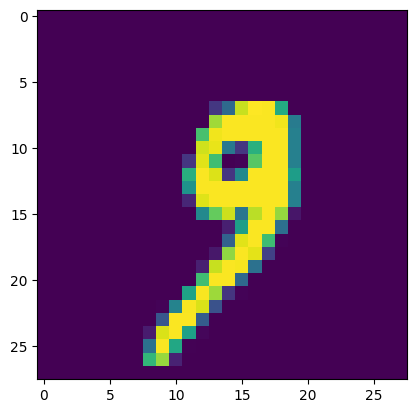

In [ ]:
# grab an image
test_img = test_data[1000][0].reshape(28,28)
# show image
plt.imshow(test_img)





In [ ]:
# pass image through model
with torch.no_grad():
    output = model(test_data[1000][0].view(1,1,28,28)) # batch size of 1, 1 color channel, 28x28 image
    print(output.argmax())

tensor(9)


tensor(8)